Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Do you clear the folder ./original_data/?, y/n: y
The folder will be cleared
Do you clear the folder ./processed_data/?, y/n: y
The folder will be cleared

Created ./processed_data/test

Created ./processed_data/train

Created ./processed_data/valid
Do you clear the folder ./trained_models/?, y/n: y
The folder will be cleared
./processed_data/test/
['./processed_data/train/metal/', './processed_data/train/cardboard/', './processed_data/train/trash/', './processed_data/train/glass/', './processed_data/train/plastic/', './processed_data/train/paper/']
['metal', 'cardboard', 'trash', 'glass', 'plastic', 'paper']
metal  -- size of non-trainset:  164 , size of trainset:  246
cardboard  -- size of non-trainset:  161 , size of trainset:  242
trash  -- size of non-trainset:  54 , size of trainset:  83
glass  -- size of non-trainset:  200 , size of trainset:  301
plas

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:105: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:04<00:00, 19220013.92it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


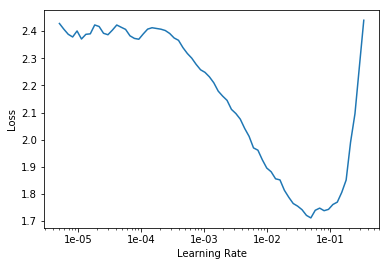

In [11]:
#!/usr/bin/python
import os
import sys
import shutil, errno
import zipfile as zf
import random
from glob import glob
from pathlib import Path

from fastai.vision import *
from fastai.metrics import error_rate


############################### Helper functions ###############################

'''
create the folders
input: folders want to create in the format "./xxx/"
output: void
'''
def create_folders(folders):
    for folder in folders:
        if not os.path.exists(folder):
            os.makedirs(folder)
            print("\nCreated", folder)
        else:
            inp = input('Do you clear the folder ' + folder + '?, y/n: ')
            if inp.lower() == "y":
                print("The folder will be cleared")
                try:
                    shutil.rmtree(folder)
                    os.makedirs(folder)
                except OSError as e:
                    print ("Error: %s - %s." % (e.filename, e.strerror))
            elif inp.lower() == "n":
                print("The folder will not be cleared")
            else:
                print("Please type y/n")
    return


'''
unzip the folder to the same path
input: zipfile to unzip
output: void
'''
def unzip(zipfile):
    files = zf.ZipFile(zipfile, 'r')
    files.extractall()
    files.close()
    
'''
move files from one folder to another
input: src folder and dst folder in format ./xxx/
output: void
'''
def move_folder(src, dst):
    try:
        files = get_subsets(src)
        for file in files:
            shutil.move(src+file, dst)
    except OSError as e:
        print ("Error: %s - %s." % (e.filename, e.strerror))
        
'''
copy files from one folder to another
input: src folder and dst folder in format ./xxx/
output: void
'''
def copy_folder(src, dst):
    try: 
        if os.path.exists(dst):
            shutil.rmtree(dst)
        shutil.copytree(src, dst)
    except OSError as e:
        if e.errno == errno.ENOTDIR:
            shutil.copy(Src, dst)
        else:
            raise

'''
get subsets (either files or folders) of the folder
input: folder path
output: list of name of subsets
'''
def get_subsets(path):
    subsets = os.listdir(path)
    for s in subsets:
        if s.startswith('.'):
            subsets.remove(s)
    return subsets

'''
get path of subsets (either files or folders) of the folder
input: folder path
output: list of subsets path
'''
def get_subsets_path(path):
    return glob(path+"*/")

#strip the name from a path
def get_name_from_path(f):
    return f[f.rindex("/")+1: ]

'''
split all data into train set and test set
input: parent path of trainset folder and testset folder, the ratio of test/all data
output: void
'''
def split_into_train_valid_and_test_sets(datapath, ratio1, ratio2):
    assert ratio1 <= 1 and ratio1 >= 0
    assert ratio2 <= 1 and ratio2 >= 0
    test_path = os.path.join(datapath, "test/")
    valid_path = os.path.join(datapath, "valid/")
    train_path = os.path.join(datapath, "train/")
    print(test_path)
    subset_paths = get_subsets_path(train_path)
    subsets = get_subsets(train_path)
    print(subset_paths)
    print(subsets)
    for i, path in enumerate(subset_paths):
        curr = subsets[i]

        temp = valid_path + curr + "/"
        os.makedirs(os.path.dirname(temp), exist_ok=True)
        
        images = glob(path + "*.jpg")
        rand = random.sample(images, int(ratio1*len(images)))
        print(curr , " -- size of non-trainset: " , len(rand) , ", size of trainset: " , (len(images)-len(rand)))

        for image in rand:
            dst = temp + get_name_from_path(image)
            os.rename(image, dst)
    
    subset_paths = get_subsets_path(valid_path)
    subsets = get_subsets(valid_path)
    print(subset_paths)
    print(subsets)
    for i, path in enumerate(subset_paths):
        curr = subsets[i]

        temp = test_path + curr + "/"
        os.makedirs(os.path.dirname(temp), exist_ok=True)
        
        images = glob(path + "*.jpg")
        rand = random.sample(images, int(ratio2*len(images)))
        print(curr , " -- size of testset: " , len(rand) , ", size of validset: " , (len(images)-len(rand)))

        for image in rand:
            dst = temp + get_name_from_path(image)
            os.rename(image, dst)
    
            
            
######################### main functions #########################          
        
###########################################################################     
######################## data preprocessing ###############################
###########################################################################
'''
create folder: original_data; processed_data

get original data
unzip file
move data to the path of folder original_Data

copy original_data and paste to processed_data so we can process data in the right folder
split dataset into test and train subset

'''

# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

# !ls "/content/drive/My Drive"
# os.chdir("../")
datapath = "./processed_data/"
test_path = os.path.join(datapath, "test")
valid_path = os.path.join(datapath, "valid")
train_path = os.path.join(datapath, "train")
folders = ["./original_data/", datapath, test_path, train_path, valid_path, "./trained_models/"]
create_folders(folders)
unzip("/content/drive/My Drive/dataset-resized.zip")
move_folder("./dataset-resized/", "./original_data")
copy_folder("./original_data/", train_path)
waste_types = get_subsets(datapath)
split_into_train_valid_and_test_sets(datapath, 0.4, 0.5)


path = Path(os.getcwd())/"processed_data"
tfms = get_transforms(do_flip=True, flip_vert=True)
data = ImageDataBunch.from_folder(path, test="test", ds_tfms=tfms, bs=16)






In [ ]:
###########################################################################     
############################ model training ###############################
###########################################################################

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


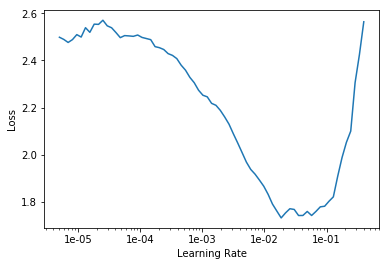

In [12]:
learn = cnn_learner(data,models.resnet34,metrics=error_rate)

learn.model

learn.lr_find(start_lr=1e-6,end_lr=1e1)
learn.recorder.plot()

In [13]:
learn.fit_one_cycle(20,max_lr=5.13e-03)

epoch,train_loss,valid_loss,error_rate,time
0,1.343077,0.752126,0.273267,00:44
1,0.848355,0.481826,0.184158,00:42
2,0.669400,0.442685,0.168317,00:45
3,0.662419,0.531601,0.182178,00:42
4,0.646940,0.692388,0.219802,00:42
5,0.614503,0.588292,0.198020,00:42
6,0.604437,0.498708,0.190099,00:41
7,0.542932,0.493228,0.160396,00:43
8,0.568036,0.437091,0.168317,00:42
9,0.480300,0.369340,0.126733,00:42


In [0]:
preds = learn.get_preds(ds_type=DatasetType.Test)

In [0]:
max_idxs = np.asarray(np.argmax(preds[0],axis=1))

In [0]:
yhat = []
for max_idx in max_idxs:
    yhat.append(data.classes[max_idx])

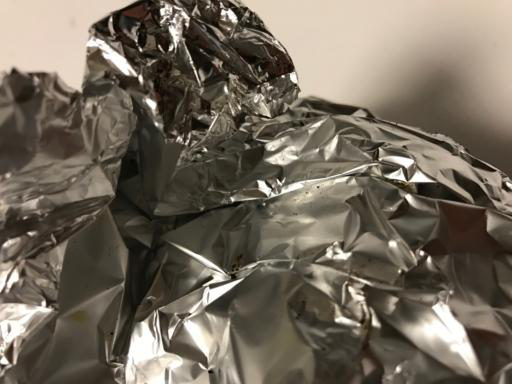

In [17]:
learn.data.test_ds[0][0]

In [0]:
y = []

## convert POSIX paths to string first
for label_path in data.test_ds.items:
    y.append(str(label_path))
    
## then extract waste type from file path
pattern = re.compile("([a-z]+)[0-9]+")
for i in range(len(y)):
    y[i] = pattern.search(y[i]).group(1)

In [19]:
## predicted values
print(yhat[0:5])
## actual values
print(y[0:5])

['metal', 'metal', 'glass', 'metal', 'metal']
['metal', 'metal', 'metal', 'metal', 'metal']


In [21]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y,yhat)
print(cm)

[[ 76   0   0   4   0   0]
 [  0  93   4   2   1   0]
 [  0   3  79   0   0   0]
 [  0   0   3 113   0   2]
 [  0   4   0   5  84   3]
 [  0   0   1   3   2  21]]


In [0]:
correct = 0

for r in range(len(cm)):
    for c in range(len(cm)):
        if (r==c):
            correct += cm[r,c]

In [23]:
accuracy = correct/sum(sum(cm))
accuracy

0.9264413518886679